# Step 1: Notebook Setup

In [3]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent  # Adjust if notebook is deeper
sys.path.append(str(project_root))

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models import *
from src.data_processing import load_merged_data, load_asset_data

# Load processed data
merged_data = load_merged_data()
tsla = load_asset_data('TSLA')
spy = load_asset_data('SPY')
bnd = load_asset_data('BND')
print(" ✅Data Loaded Successfully")

 ✅Data Loaded Successfully


# Step 2: Data Preparation

In [4]:
# Use adjusted closing prices
prices = merged_data[['TSLA', 'SPY', 'BND']]  # Or use the individual DataFrames

# Split into train/test (last 20% for testing)
test_size = int(len(prices) * 0.2)
train = prices.iloc[:-test_size]
test = prices.iloc[-test_size:]

# Step 3: ARIMA Implementation


--- ARIMA Modeling for TSLA ---


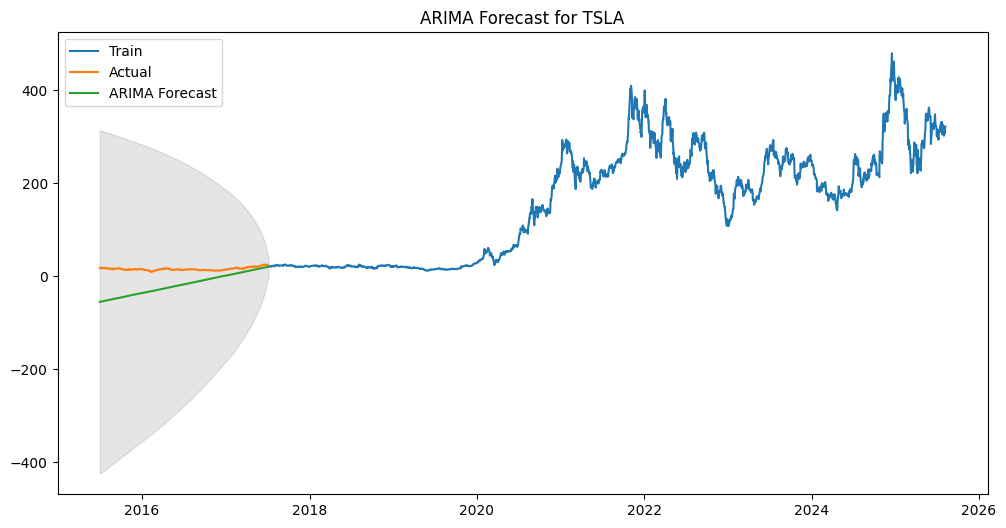


--- ARIMA Modeling for SPY ---


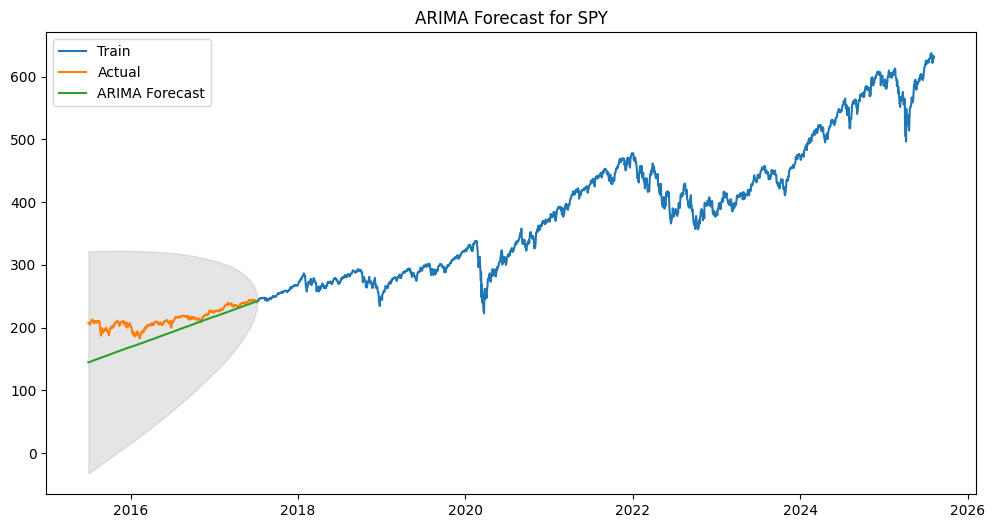


--- ARIMA Modeling for BND ---


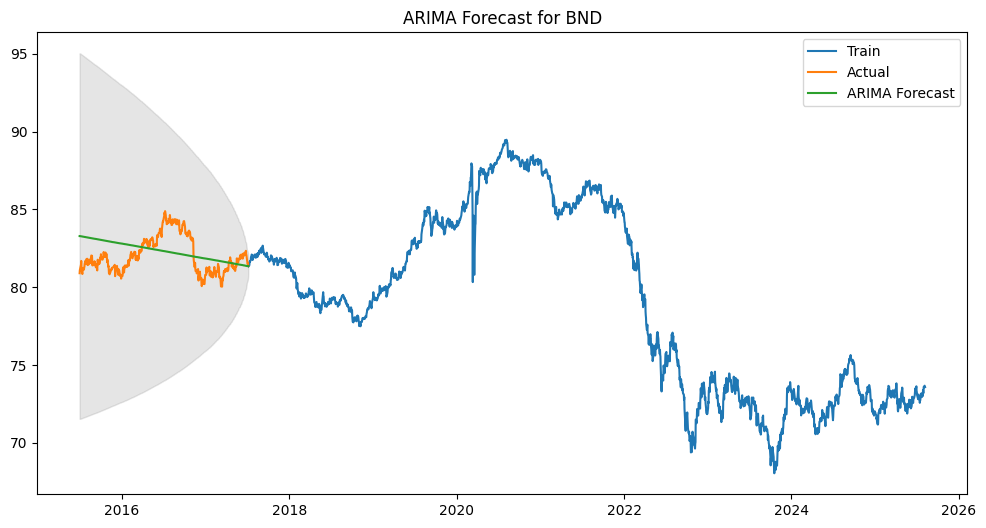

In [6]:
# For each asset
for ticker in ['TSLA', 'SPY', 'BND']:
    print(f"\n--- ARIMA Modeling for {ticker} ---")
    
    # Train ARIMA
    arima_model = train_arima(train[ticker], order=(3,1,2))
    
    # Forecast
    arima_forecast, conf_int = forecast_arima(arima_model, test[ticker])
    
    # Create proper index for confidence intervals
    conf_int_df = pd.DataFrame(conf_int, 
                              index=test[ticker].index,
                              columns=['lower', 'upper'])
    
    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(train[ticker], label='Train')
    plt.plot(test[ticker], label='Actual')
    plt.plot(arima_forecast, label='ARIMA Forecast')
    
    # Fixed confidence interval plotting
    plt.fill_between(conf_int_df.index,
                   conf_int_df['lower'],
                   conf_int_df['upper'],
                   color='gray', alpha=0.2)
    
    plt.title(f'ARIMA Forecast for {ticker}')
    plt.legend()
    plt.show()

# Step 4: LSTM Implementation

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


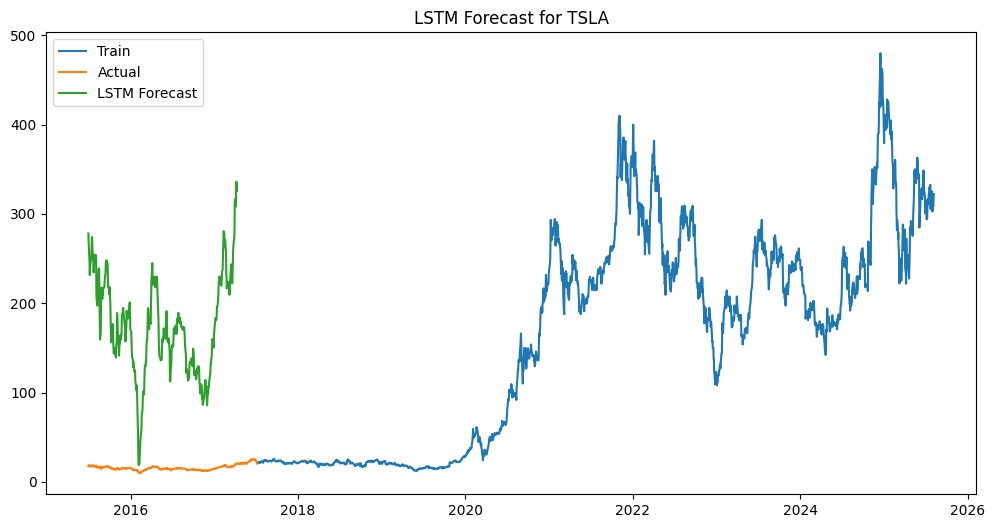

In [8]:
# Prepare LSTM data
n_steps = 60
X_train, y_train, scaler = prepare_lstm_data(train['TSLA'], n_steps=n_steps)
X_test, y_test, _ = prepare_lstm_data(test['TSLA'], n_steps=n_steps, additional_features=None)

# Build and train LSTM
lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=32, 
                        validation_split=0.1,
                        verbose=0)  # <-- This turns off progress bars
# Make predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1,1)).flatten()

# Create date index for predictions
pred_index = test['TSLA'].index[n_steps:]
lstm_forecast = pd.Series(lstm_pred, index=pred_index)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train['TSLA'], label='Train')
plt.plot(test['TSLA'], label='Actual')
plt.plot(lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Forecast for TSLA')
plt.legend()
plt.show()

# Step 5: Hybrid Model (Optional)

In [9]:
# Create hybrid model
hybrid_model = create_hybrid_model(arima_model, lstm_model, arima_weight=0.4)



# Step 6: Model Evaluation

In [10]:
# Evaluate all models
forecasts = {
    'ARIMA': arima_forecast,
    'LSTM': lstm_forecast,
    # 'Hybrid': hybrid_forecast
}

results = evaluate_forecasts(test['TSLA'], forecasts)
print("\nModel Performance Comparison:")
print(results)


Model Performance Comparison:
           ARIMA         LSTM
MAE    66.433559   158.407301
RMSE   66.512466   167.158395
MAPE  434.596980  1025.402048


# Step 7: Save Results

In [12]:
# Save forecasts
forecasts_df = pd.DataFrame({
    'Actual': test['TSLA'],
    'ARIMA': arima_forecast,
    'LSTM': lstm_forecast
}).dropna()

forecasts_df.to_csv('../outputs/forecasts/TSLA_forecasts.csv')

# Save model performance
results.to_csv('../outputs/forecasts/model_performance.csv')
print(" ✅ Data Saved Succesfully")

 ✅ Data Saved Succesfully
